In [1]:
import json
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mnist_loader

mpl.rcParams['figure.dpi'] = 100

In [2]:
#### Cost functions and their derivatives
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def derivative(z, a, y):
        return (a-y) * sigmoid_prime(z)

class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def derivative(z, a, y):
        return (a-y)

#### Main Network class
class Network(object):
    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.cost=cost

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def stochastic_gradient_descent(self, training_data, epochs, mini_batch_size, learning_rate,
            regualrization_method = 'l2',
            regularization_rate = 0.0,
            evaluation_data=None,
            early_stopping_n=0,
            export_params=False,
            log_accuracy=False):

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        cst = 'unknowncost'
        if self.cost is QuadraticCost:
            cst = 'qcost'
        if self.cost is CrossEntropyCost:
            cst = 'xcost'
        rm = '0l'
        if regualrization_method == 'l1':
            rm = '1l'
        if regualrization_method == 'l2':
            rm = '2l'
        es = '0stop'
        if early_stopping_n > 0:
            es = '1stop'
        var_name = f'data_{cst}_{rm}_{es}'

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        print(f"Epoch of training complete of {epochs}: ", end='')
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate, regularization_rate, regualrization_method, len(training_data))

            print(f"{j} ", end='')

            if export_params is False:
                t_cost = self.total_cost(training_data)
                training_cost.append(t_cost)

                t_accuracy = round(self.accuracy(training_data, convert=True) * 100 / n, 2)
                training_accuracy.append(t_accuracy)

                e_cost = self.total_cost(evaluation_data, convert=True)
                evaluation_cost.append(e_cost)

                e_accuracy = round(self.accuracy(evaluation_data) * 100 / n_data, 4)
                evaluation_accuracy.append(e_accuracy)
                if log_accuracy:
                    print(f'accuracy on evaluation data {e_accuracy}')
                        
            # Early stopping:
            if early_stopping_n > 0:
                if e_accuracy > best_accuracy:
                    best_accuracy = e_accuracy
                    no_accuracy_change = 0
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    print(f"Early-stopping: No accuracy change in last {early_stopping_n} epochs")
                    actual_epochs = j+1
                    if export_params:
                        with open(f'{var_name}.json', 'w') as outfile:
                            outfile.write(f'{var_name} = ')
                            json.dump({
                                "weights": self.weights,
                                "biases": self.biases
                            }, outfile, cls=NumpyEncoder)
                        print(f'model saved to {var_name}.json', end='')
                        return
                    return training_accuracy, evaluation_accuracy, training_cost, evaluation_cost, actual_epochs
        
        if export_params:
            with open(f'{var_name}.json', 'w') as outfile:
                outfile.write(f'{var_name} = ')
                json.dump({
                    "weights": self.weights,
                    "biases": self.biases
                }, outfile, cls=NumpyEncoder)
            print(f'model saved to {var_name}.json', end='')
            return
        print('')
        return training_accuracy, evaluation_accuracy, training_cost, evaluation_cost, epochs

    def update_mini_batch(self, mini_batch, learning_rate, regularization_rate, regualrization_method, total_num_training_examples):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        weight_decay_fn = weight_decay(regualrization_method, regularization_rate, learning_rate, total_num_training_examples)
        self.weights = [weight_decay_fn(w)-(learning_rate/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(learning_rate/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, input_activations, target_vector):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = input_activations
        activations = [input_activations]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).derivative(zs[-1], activations[-1], target_vector)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        return cost

#### Miscellaneous functions
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def weight_decay(regualrization_method, regularization_rate, learning_rate, total_num_training_examples):
    l1 = lambda w: (w - (1 if w > 0 else -1)*learning_rate*(regularization_rate/total_num_training_examples))
    weight_decay_fn = lambda w: w
    if regualrization_method == 'l2':
        weight_decay = lambda w: (1-learning_rate*(regularization_rate/total_num_training_examples)) * w
    if regualrization_method == 'l1':
        weight_decay = lambda w: l1(w)
    return weight_decay_fn

class NumpyEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.ndarray):
      return obj.tolist()
    return json.JSONEncoder.default(self, obj)


## Fine-tuning Hyperprameters

I've found the hyperparameters  that work best with this network are:
cost_function = CrossEntropy
mini_batch_size = 10
learning_rate = 0.1
regualrization_method = L2
regularization_rate = 1
early_stopping = True (stop after 2 epochs of no improvement)

With a final accuracy on the evaluation data of 96.4%

In [137]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
net = Network([784, 25, 25, 10], cost=CrossEntropyCost)
a, b, c, d, e, = net.stochastic_gradient_descent(
  training_data, 30, 10, 0.1,
  regualrization_method='l2',
  regularization_rate=1,
  evaluation_data=validation_data,
  early_stopping_n=2,
  log_accuracy=True)

Epoch of training complete of 30: 0 accuracy on evaluation data 91.41
1 accuracy on evaluation data 94.23
2 accuracy on evaluation data 95.17
3 accuracy on evaluation data 95.54
4 accuracy on evaluation data 96.01
5 accuracy on evaluation data 96.03
6 accuracy on evaluation data 95.99
7 accuracy on evaluation data 96.24
8 accuracy on evaluation data 96.01
9 accuracy on evaluation data 96.45
10 accuracy on evaluation data 96.43
11 accuracy on evaluation data 96.42
Early-stopping: No accuracy change in last 2 epochs


Below are the experiments run to determine the optimal hyperparameters

In [3]:
# Helper functions to run experiments
# will train a net multiple times with different paramerters and plot the results
def compareParameters(param_name, params, net_builder):

  colors = ['red', 'green', 'blue', 'black', 'orange', 'purple', 'magenta', 'cyan', 'lime']

  accuracy_fig, accuracy_ax = plt.subplots()
  accuracy_ax.set_xlabel('Epoch')
  accuracy_ax.set_ylabel('Accuracy')
  accuracy_ax.set_title("Evaluation Accuracy")

  cost_fig, cost_ax = plt.subplots()
  cost_ax.set_xlabel('Epoch')
  cost_ax.set_ylabel('Cost')
  cost_ax.set_title("Evaluation Cost")

  for i, param in enumerate(params):
    training_accuracy, evaluation_accuracy, training_cost, evaluation_cost, actual_epochs = net_builder(param)
    accuracy_ax.plot(range(actual_epochs), evaluation_accuracy, color=colors[i], label=f'{param_name} = {param}')
    cost_ax.plot(range(actual_epochs), evaluation_cost, color=colors[i], label=f'{param_name} = {param}')
  
  accuracy_ax.legend()
  cost_ax.legend()

def compareRegularization(param_name, params, net_builder):
  for param in params:
    training_accuracy, evaluation_accuracy, training_cost, evaluation_cost, actual_epochs = net_builder(param)

    fig, ax1 = plt.subplots()
    ax1.set_title(f'{param_name}: {param}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy', color="blue")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.plot(range(actual_epochs), training_accuracy, color='blue', label='train acc')
    ax1.plot(range(actual_epochs), evaluation_accuracy, color='cyan', label='eval acc')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost', color="red")
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.plot(range(actual_epochs), training_cost, color='red', label='train cost')
    ax2.plot(range(actual_epochs), evaluation_cost, color='magenta', label='eval cost')

    ax1.legend()
    ax2.legend()



The learning rate of 0.1 yeilded the highest accuracy and the lowest cost on the evaluation data after 20 epochs

Epoch of training complete of 20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Epoch of training complete of 20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Epoch of training complete of 20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Epoch of training complete of 20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


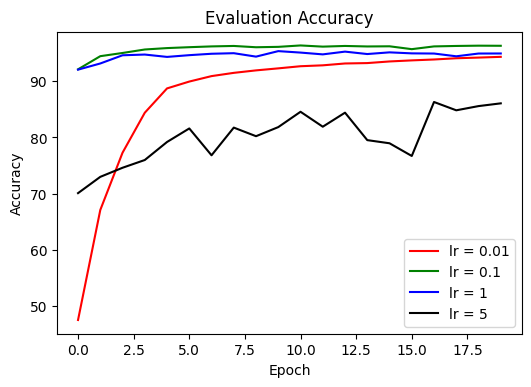

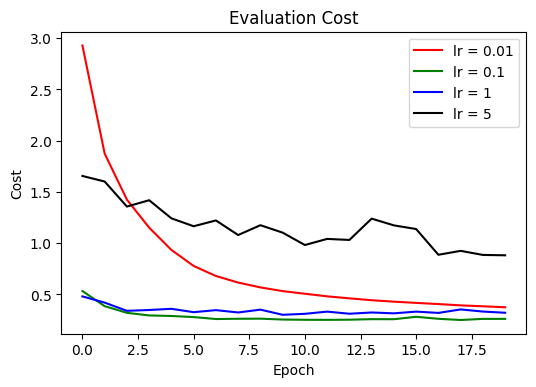

In [131]:
def lr_net_builder(param):
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
  net = Network([784, 25, 25, 10], cost=CrossEntropyCost)
  return net.stochastic_gradient_descent(
    training_data, 20, 10, param,
    regularization_rate = 5.0,
    evaluation_data=validation_data)

compareParameters('lr', [0.01, 0.1, 1, 5], lr_net_builder)

The regualrization types are all very comperable when looking at this experiment, however, L2 regularization seems to have a slight dampening effect on overfitting

Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


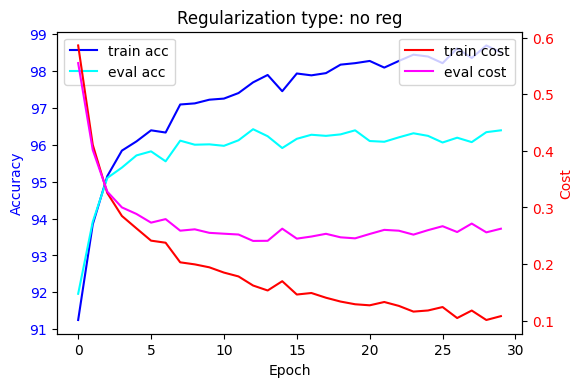

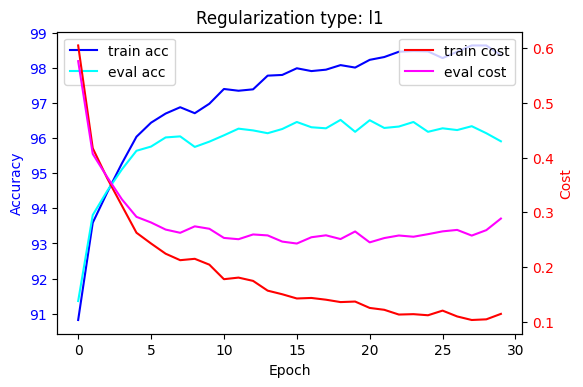

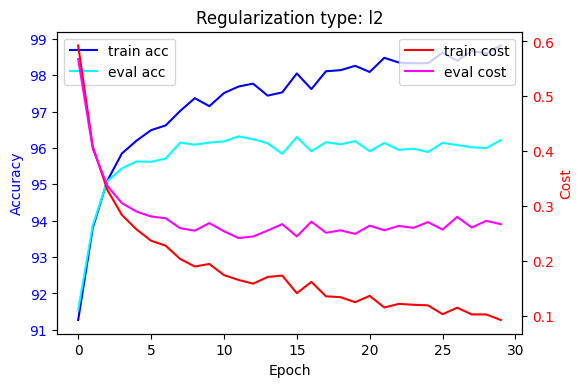

In [126]:
def reg_type_net_builder(param):
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
  net = Network([784, 25, 25, 10], cost=CrossEntropyCost)
  return net.stochastic_gradient_descent(
    training_data, 30, 10, 0.1,
    regualrization_method=param,
    regularization_rate = 5.0,
    evaluation_data=validation_data)

compareRegularization('Regularization type', ['no reg', 'l1', 'l2'], reg_type_net_builder)

The regualrization values are all very comperable when looking at this experiment, however, the regularization rateof 1 seems to have a slight dampening effect on overfitting

Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


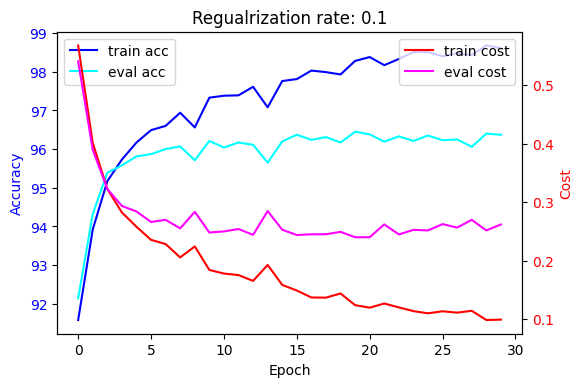

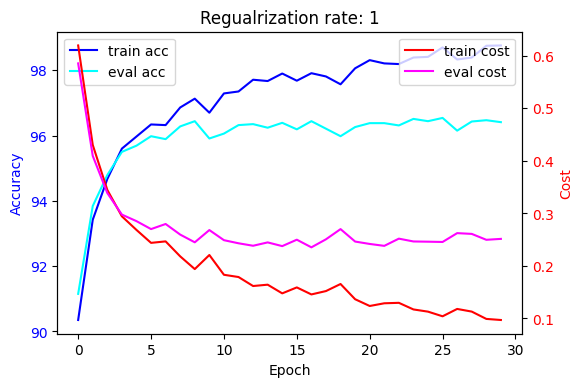

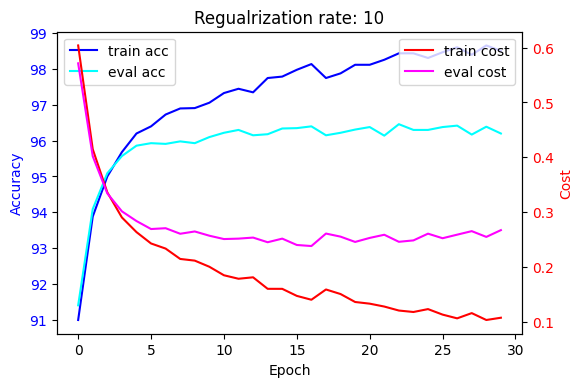

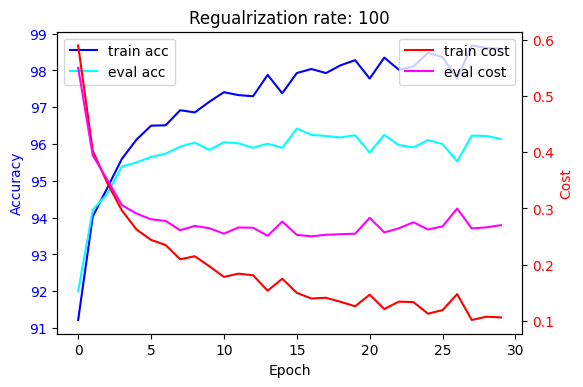

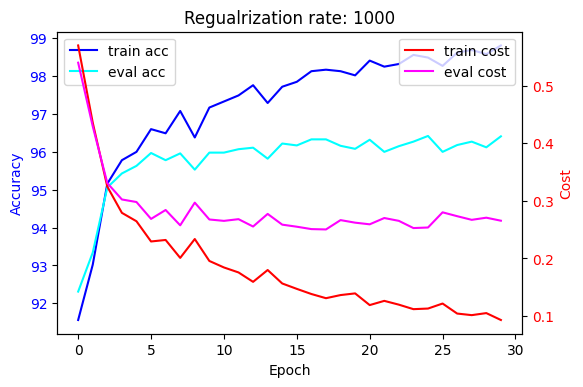

In [127]:
def reg_rate_net_builder(param):
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
  net = Network([784, 25, 25, 10], cost=CrossEntropyCost)
  return net.stochastic_gradient_descent(
    training_data, 30, 10, 0.1,
    regualrization_method='l2',
    regularization_rate=param,
    evaluation_data=validation_data)

compareRegularization('Regualrization rate', [0.1, 1, 10, 100, 1000], reg_rate_net_builder)

Early stopping after 2 epochs of no accuracy improvement seems to be optimal for this network accrding to this experiment

Epoch of training complete of 30: 0 1 2 3 4 Early-stopping: No accuracy change in last 1 epochs
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 Early-stopping: No accuracy change in last 2 epochs
Epoch of training complete of 30: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Early-stopping: No accuracy change in last 3 epochs


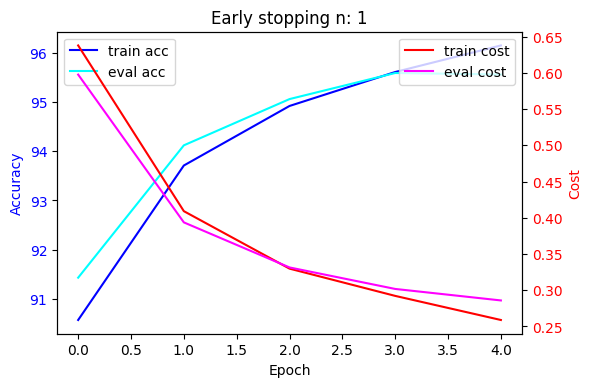

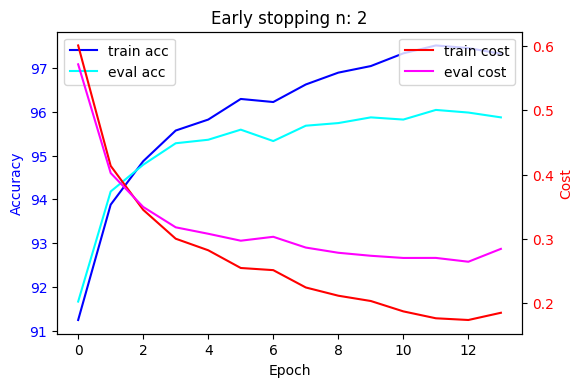

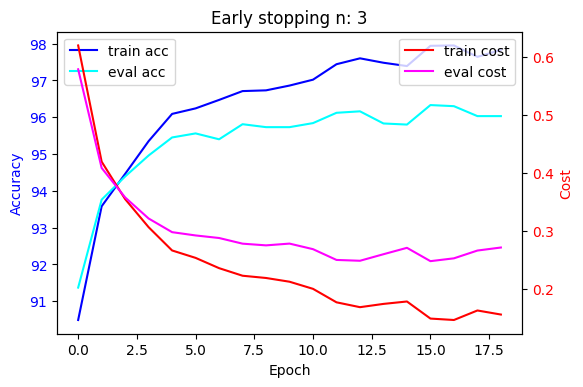

In [128]:
def early_stop_net_builder(param):
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
  net = Network([784, 25, 25, 10], cost=CrossEntropyCost)
  return net.stochastic_gradient_descent(
    training_data, 30, 10, 0.1,
    regualrization_method='l2',
    regularization_rate=1,
    evaluation_data=validation_data,
    early_stopping_n=param)

compareRegularization('Early stopping n', [1, 2, 3], early_stop_net_builder)